# Classification. Linear models and KNN

In [463]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [464]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler


## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [465]:
from sklearn.exceptions import NotFittedError

In [554]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        sigmoid = []
        for i in range(X.shape[0]):
            sigmoid.append(1 / (1 + np.exp(-np.dot(weights, X[i]))))
        return sigmoid

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        X_ext = np.hstack([np.ones((x.shape[0], 1)), x])
        sum = 0
        for i in range(X_ext.shape[0]):
            sum += np.log(1 + np.exp(-np.dot(self.weights_, X_ext[i]) * y[i])) + (np.linalg.norm(weights) ** 2) / (2 * self.C)
        return sum / X_ext.shape[0]
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features)
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss = []

        for i in range(self.max_iter):
            sum = np.zeros(num_features)
            for j in range(X_ext.shape[0]):
                sum += y[j] * X_ext[j] * (1 - (1 / (1 + np.exp(-np.dot(self.weights_, X_ext[j]) * y[j]))))
            sum /= X_ext.shape[0]
            delta = -sum + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss.append(self.get_loss(X, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        y = []
        for i in range(X.shape[0]):
            y.append(np.sign(np.dot(self.weights_, X_ext[i])))
        return y

In [555]:
from sklearn import datasets
from sklearn import metrics

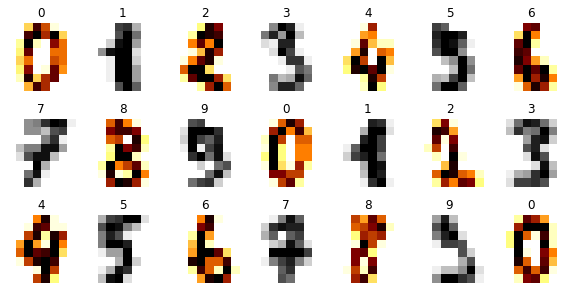

In [556]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [557]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [558]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [559]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [560]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [561]:
lr_clf.fit(X_train, y_train)

In [562]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [563]:
model = CustomLogisticRegression()

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


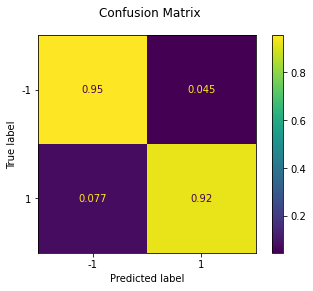

In [564]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [565]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [566]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

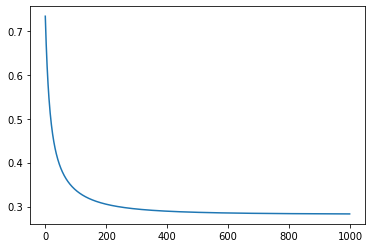

In [568]:
plt.plot(model.loss);

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


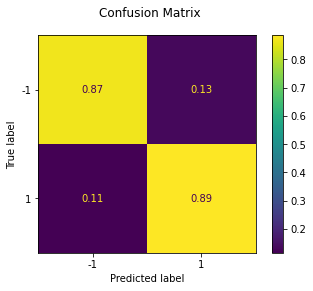

(0.848990953375087, 0.8777777777777778)

In [581]:
graph1 = CustomLogisticRegression(eta=0.00001)
fit_evaluate(graph1, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


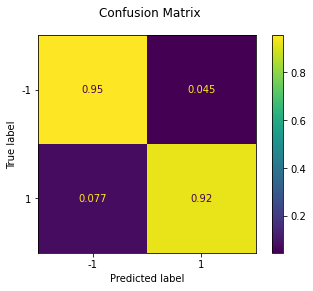

(0.9109255393180237, 0.9388888888888889)

In [582]:
graph2 = CustomLogisticRegression(eta=0.001)
fit_evaluate(graph2, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


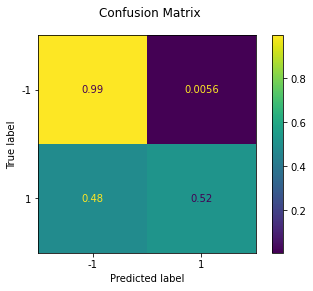

(0.7731384829505915, 0.7527777777777778)

In [583]:
graph3 = CustomLogisticRegression(eta=0.01)
fit_evaluate(graph3, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


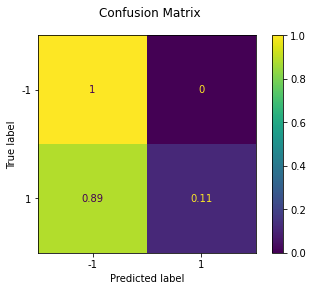

(0.5671537926235213, 0.55)

In [584]:
graph4 = CustomLogisticRegression(eta=0.05)
fit_evaluate(graph4, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


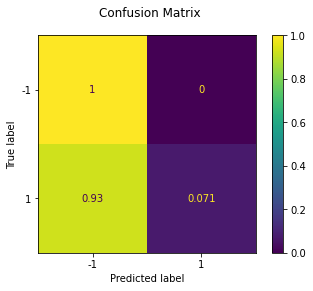

(0.5455810716771051, 0.5277777777777778)

In [585]:
graph5 = CustomLogisticRegression(eta=0.1)
fit_evaluate(graph5, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_13280\1213542582.py:41: RuntimeWarning: overflow encountered in exp
  sum += np.log(1 + np.exp(-np.dot(self.weights_, X_ext[i]) * y[i])) + (np.linalg.norm(weights) ** 2) / (2 * self.C)
C:\Users\HP\AppData\Local\Temp\ipykernel_13280\1213542582.py:65: RuntimeWarning: overflow encountered in exp
  sum += y[j] * X_ext[j] * (1 - (1 / (1 + np.exp(-np.dot(self.weights_, X_ext[j]) * y[j]))))
C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


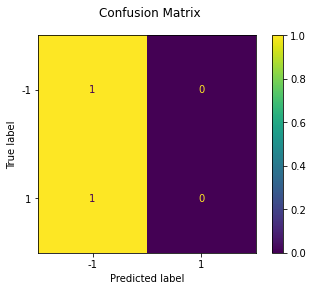

(0.4968684759916493, 0.49166666666666664)

In [587]:
graph6 = CustomLogisticRegression(eta=1)
fit_evaluate(graph6, X_train, y_train, X_test, y_test)

При наименьшей скорости предсказания лучше, но нам потребуется и больше времени на обучение и вычислительных мощностей.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


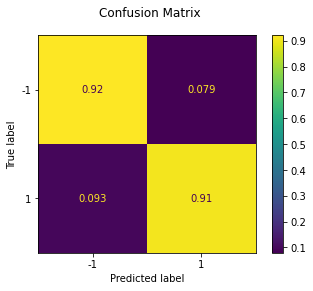

(0.8879610299234516, 0.9138888888888889)

In [596]:
graph7 = CustomLogisticRegression(C=0.1)
fit_evaluate(graph7, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


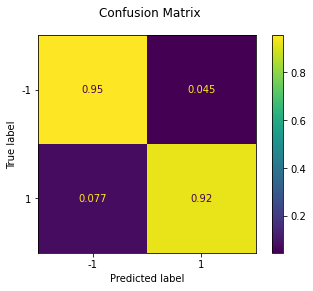

(0.9109255393180237, 0.9388888888888889)

In [597]:
graph8 = CustomLogisticRegression(C=1)
fit_evaluate(graph8, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


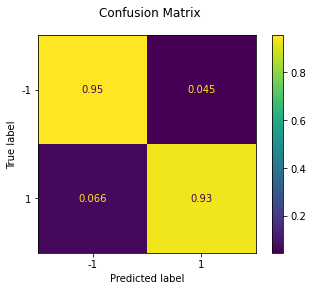

(0.9151009046624913, 0.9444444444444444)

In [598]:
graph9 = CustomLogisticRegression(C=5)
fit_evaluate(graph9, X_train, y_train, X_test, y_test)

Как видно из графиков, чем больше значение параметра регуляризации, тем меньше значение функции потерь, то есть регуляризация не дает модели переобучиться.

**(0.5 points)** Compare zero initialization and random initialization. 

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


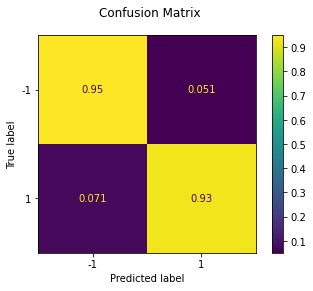

train accuracy_with zero initialization  0.9116214335421016
test accuracy_with zero initialization  0.9388888888888889


C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


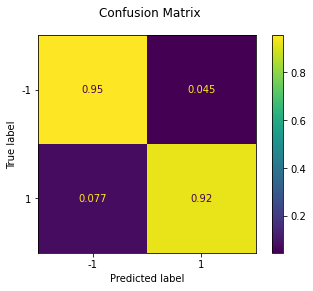

train accuracy_with random initialization  0.9109255393180237
test accuracy_with random initialization  0.9388888888888889


In [591]:
model = CustomLogisticRegression()
model.zero_init = True
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train accuracy_with zero initialization ', train_acc)
print('test accuracy_with zero initialization ', test_acc)

model = CustomLogisticRegression()
model.zero_init = False
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
print('train accuracy_with random initialization ', train_acc)
print('test accuracy_with random initialization ', test_acc)

Как видно из графиков различия не столько существенны

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [606]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        from sklearn.metrics import pairwise_distances
        return pairwise_distances(X,Y)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        w = []
        for i in self.classes_:
            s = 0
            for j in range(len(y)):
                if y[j] == i:
                    s += weights[j]
            w.append(s)
        return w
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = np.ones(P.shape) / (P + self.eps)
                
            y = np.zeros((X.shape[0], len(self.classes_)))
            for i, sample in enumerate(P):
                neighbors = np.argsort(sample)[:self.n_neighbors]
                neighbor_classes = self.y[neighbors]
                y[i] = self.get_class_weights(neighbor_classes, weights_of_points[i][neighbors])
                y[i] /= np.sum(y[i])
                
            return y
            
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        return np.argmax(self.predict_proba(X), axis=1)

In [607]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [608]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [609]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

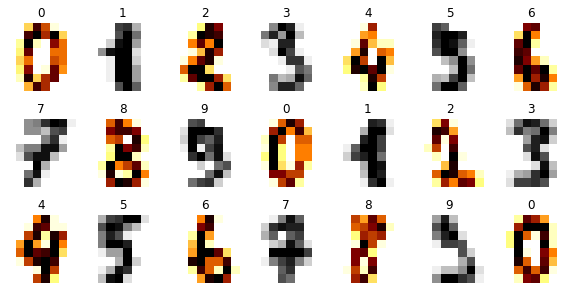

In [610]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [611]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [612]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


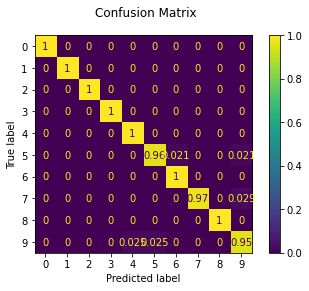

In [613]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [614]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Как видно из графика, модель путает числа (9, 4, 5); (5, 6, 9) и (7, 9). Возможно это происходит потому, что они схожи по форме (пиксели?).

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


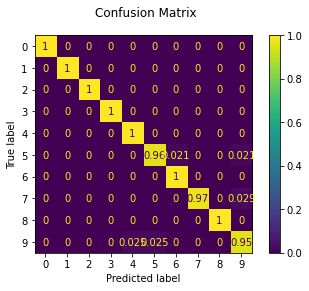

(1.0, 0.9861111111111112)

In [628]:
graph10 = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
fit_evaluate(graph10, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


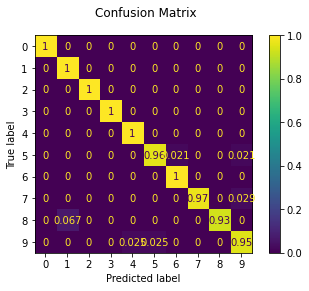

(1.0, 0.9805555555555555)

In [627]:
graph11 = CustomKNeighborsClassifier(n_neighbors=10, weights='distance')
fit_evaluate(graph11, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


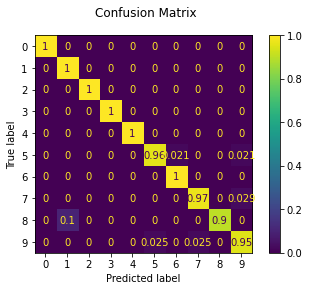

(1.0, 0.9777777777777777)

In [626]:
graph12 = CustomKNeighborsClassifier(n_neighbors=20, weights='distance')
fit_evaluate(graph12, X_train, y_train, X_test, y_test)

Как видно из графика при меньшем количестве neighbors отмечается худшая точность из-за влияния шума, для большего - лучшую.
Но при большом количестве neighbor увеличивается и необходмая мощность

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


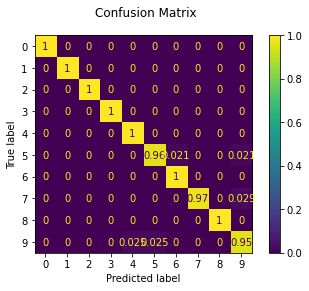

(0.9895615866388309, 0.9861111111111112)

In [629]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
fit_evaluate(knn, X_train, y_train, X_test, y_test)

C:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


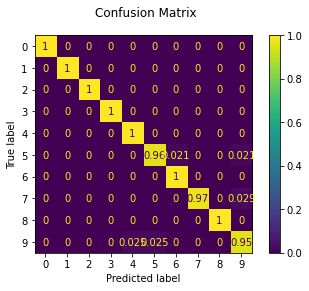

(1.0, 0.9861111111111112)

In [630]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
fit_evaluate(knn, X_train, y_train, X_test, y_test)

Как видно из графиков, результаты одинаковы. Возможно, разница может быть заметна на несбалансированных наборах данных, и в этом случае лучше использовать "неравномерные" веса, чтобы избежать выбросов.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

Например, Manhattan distance

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [279]:
PATH = ""

In [280]:
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [281]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [282]:
# пропущенные значения 
missing_percentages = (train_data[train_data.columns].isnull().sum() / train_data.shape[0]) * 100
missing_percentages

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

In [283]:
# уникальные значения 
for i in train_data.columns:
    print("Кол-во уникальных значений в {} - {}".format(i, len(train_data[i].unique())))

Кол-во уникальных значений в Survived - 2
Кол-во уникальных значений в Pclass - 3
Кол-во уникальных значений в Name - 92144
Кол-во уникальных значений в Sex - 2
Кол-во уникальных значений в Age - 174
Кол-во уникальных значений в SibSp - 7
Кол-во уникальных значений в Parch - 8
Кол-во уникальных значений в Ticket - 75332
Кол-во уникальных значений в Fare - 15936
Кол-во уникальных значений в Cabin - 26993
Кол-во уникальных значений в Embarked - 4


In [284]:
# Проверка на дубликаты
train_data.duplicated().sum()

0

### EDA

! Большую часть анализа брал из ранее проведенного EDA (2 - Descriptive Statistics and Data Exploration)

Прилагаю на всякий случай к материалам

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

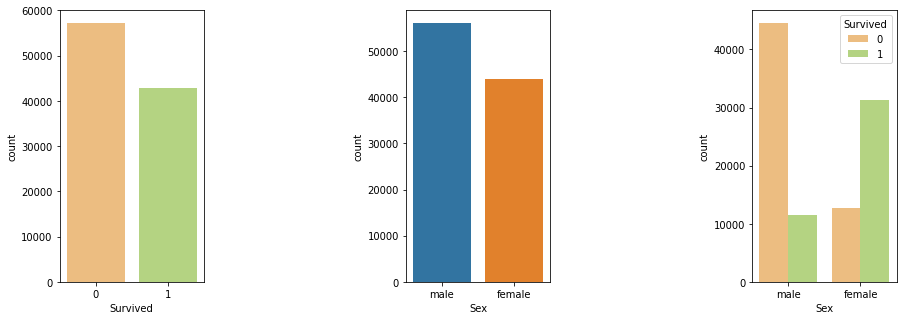

In [285]:
# распределение 'Survived', 'Sex', 'Sex/Survived'
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt.subplot(1,5,1)
ax = sns.countplot(x="Survived",data=train_data, palette='RdYlGn')
plt.subplot(1,5,3)
ax = sns.countplot(x="Sex",data=train_data)
plt.subplot(1,5,5)
ax = sns.countplot(x="Sex", hue='Survived', data=train_data, palette='RdYlGn')

In [286]:
# распределение 'Survived'
print(pd.pivot_table(train_data, columns = 'Survived', values = 'Name' , aggfunc='count'))
print()
# распределение 'Sex'
print(pd.pivot_table(train_data, columns = 'Sex', values = 'Name' , aggfunc='count'))
print()
# распределение 'Sex/Survived', относительные значения (%)
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Sex', values = 'Name' , aggfunc='count')
          /train_data.Sex.value_counts()*100)

Survived      0      1
Name      57226  42774

Sex   female   male
Name   43886  56114

             female       male
Survived                      
0         28.847468  79.420465
1         71.152532  20.579535


- `Survived` : общее кол-во погибших (57 226 или 57.2%) превышает кол-во выживших (42 774 или 42.8%);
- `Sex` : на борту мужчин (56 114 или 56.1%) было больше чем женщин (43 886 или 43.9%);
- `Sex -- Survived` : женищины имели большое шансов выжить (71.2% выживших, 28.8% погибших), у мужчин - обратная тенденция (20.6 и 79.4% соответственно). Можно предположить, что это связано с тем, что женщин (и детей) спасают первыми.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

медианный возраст пассажиров: 39.0
средний возраст пассажиров: 38.35547214294577


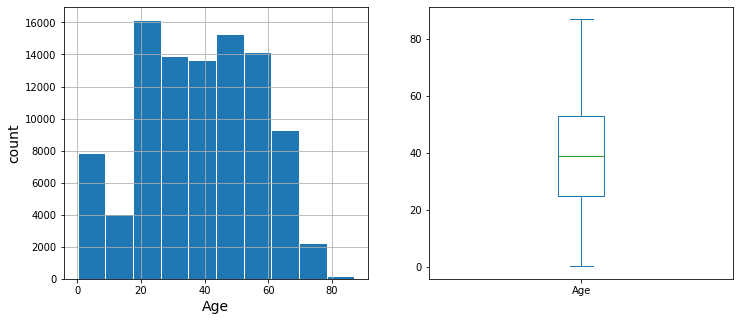

In [287]:
# распределение 'Age'
plt.subplot(1,2,1)
train_data['Age'].hist(figsize=(12,5),bins=10,edgecolor='white')
plt.xlabel('Age',fontsize=14)
plt.ylabel('count',fontsize=14)

plt.subplot(1,2,2)
train_data['Age'].plot.box(figsize=(12,5))

# медиана и среднее по `Age`
print ('медианный возраст пассажиров:',train_data.Age.median()) 
print ('средний возраст пассажиров:',train_data.Age.mean())

медианный возраст погибших: 36.0
медианный возраст выживших: 43.0
средний возраст погибших: 36.70869488153374
средний возраст выживших 40.553799314307795


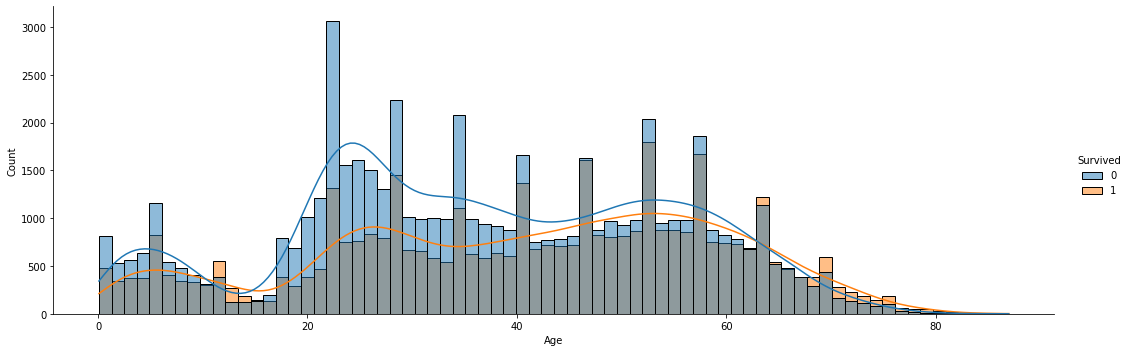

In [288]:
# распределение 'Age/Survived'
sns.displot(data=train_data, x='Age', hue='Survived', kde=True, height=5, aspect=3)

# медиана и среднее по `Age/Survived`
print ('медианный возраст погибших:', train_data[train_data['Survived'] == 0]['Age'].median())
print ('медианный возраст выживших:', train_data[train_data['Survived'] == 1]['Age'].median())
print ('средний возраст погибших:', train_data[train_data['Survived'] == 0]['Age'].mean())
print ('средний возраст выживших', train_data[train_data['Survived'] == 1]['Age'].mean())

- `Age` : признак имеет мультимодальное распределение. При этом медиана и среднее практически равны: 39.0 и 38.4 соответственно;
- `Age -- Survived` : медианный и средний возраст выживших несколько больше, чем погибших, хоть и незначительно. Средний и мединанный возраст погибших практический равный: 36.7 и 36.0 соответственно. На графике видно, что молодые люди ~ от 18 до 42 лет погибали чаще, чем другие. Выживаемость среди пожилых, а также детей ~ от 14 до 17, напротив, была несколько выше.

   Пропущенные значения предлагается заполнить медианными значениями.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

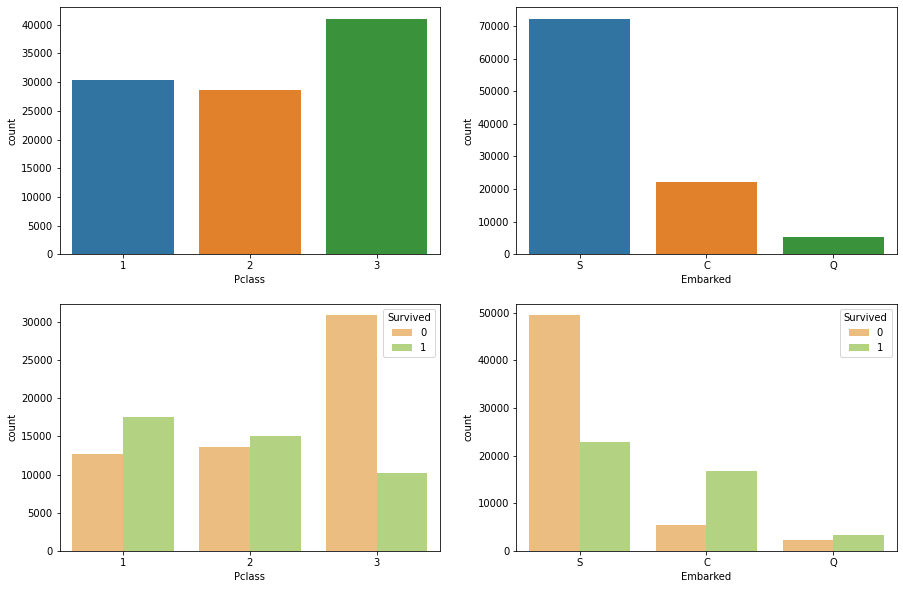

In [289]:
# распределение 'Pclass','Embarked', 'Pclass/Survived', 'Embarked/Survived'
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

plt.subplot(2,2,1)
ax = sns.countplot(x="Pclass", data=train_data)

plt.subplot(2,2,2)
ax = sns.countplot(x="Embarked", data=train_data)

plt.subplot(2,2,3)
ax = sns.countplot(x="Pclass", hue='Survived', data=train_data, palette='RdYlGn')

plt.subplot(2,2,4)
ax = sns.countplot(x="Embarked", hue='Survived', data=train_data, palette='RdYlGn')


In [290]:
print(pd.pivot_table(train_data, columns = 'Pclass', values = 'Name' , aggfunc='count'))
print()
print(pd.pivot_table(train_data, columns = 'Embarked', values = 'Name' , aggfunc='count'))
print()
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Pclass', values = 'Name' , aggfunc='count')
          /train_data.Pclass.value_counts()*100)
print()
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Embarked', values = 'Name' ,aggfunc='count')
           /train_data.Embarked.value_counts()*100)

Pclass      1      2      3
Name    30315  28679  41006

Embarked      C     Q      S
Name      22187  5424  72139

                  1          2          3
Survived                                 
0         42.022101  47.498169  75.269473
1         57.977899  52.501831  24.730527

                 C         Q          S
Survived                               
0         24.87042  40.30236  68.470591
1         75.12958  59.69764  31.529409


- `Pclass` : большинство пассажиров плыли 3 классом (41 006 или 41.0%), 1 и 2 - практически поровну (30 315 или 30.3% и 28 679 или 28.7% соответственно);
- `Embarked` : место посадки большинства пассажиров был Southampton (72 139 или 72.1%), затем Cherbourg (22 187 или 22.2%) и незначительная часть пассажиров села в Queenstown (5 424 или 5.4%). Учитывая, что % пропущенных значений признака незначительный (0.25%) пропущенные значения предлагается заполнить модой;
- `Pclass -- Survived` : пассижиры, плывшие 1 или 2 классом имели большое шансов выжить (58.0% выживших, 42.0% погибших и 52.5% выживших, 47.5% погибших соответственно), 3 классом - обратная тенденция (24.7% выживших, 75.3% погибших). Возможно, высокая выживаемость пассажиров 1 и 2 класса и низкая - пассажиров 3 класса - связана с расположением кают на корабле (каюты 1 и 2 корабля находились выше) или тем, что пассажирам 1 и 2 класса полагались спасательные шлюпки, а для пассажиров 3 класса их было меньше (не хватило).
- `Embarked -- Survived` : пассажиры, севшие на рейс в Cherbourg (C) или Queenstown (Q) имели большое шансов выжить (58.0% выживших, 42.0% погибших и 52.5% выживших, 47.5% погибших соответственно), в Southampton (S) - обратная тенденция. !Но при этом отмечается, что на рейс в Cherbourg или Queenstown село больше женщин, а также пассажиров плывших 1 и 2 классом, в Southampton - обратная тенденция. То есть, можно преположить, что между переменной `Embarked` и `Survived` нет прямой причинной-следственной связи, `Survived` зависит от характеристик пассажиров (`Sex`, `Pclass`), севших в этих населенных пунктах `Embarked`. Но можно предположить, что `Embarked` влияет на характеристики пассажиров - например, что в Cherbourg живут преимущественно женщины с достатком, которые могут позволить себе плыть 1 классом.

### Дополнительный анализ
###  Fare

медианное значение стоимости билета: 24.46
среднее значение стоимости билета: 43.92933040273968


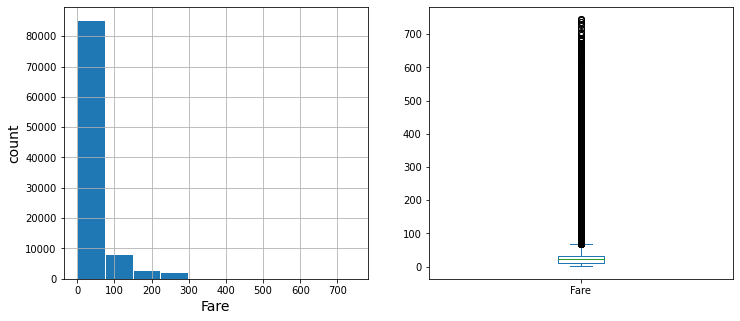

In [291]:
# распределение 'Fare', 'Fare/Pclass'
plt.subplot(1,2,1)
train_data['Fare'].hist(figsize=(12,5),bins=10,edgecolor='white')
plt.xlabel('Fare',fontsize=14)
plt.ylabel('count',fontsize=14)

plt.subplot(1,2,2)
train_data['Fare'].plot.box(figsize=(12,5))

# медиана и среднее по `Fare`
print ('медианное значение стоимости билета:',train_data.Fare.median()) 
print ('среднее значение стоимости билета:',train_data.Fare.mean())

медианное значение стоимости билета 1 класса: 63.58
медианное значение стоимости билета 2 класса: 22.72
медианное значение стоимости билета 3 класса: 10.96
среднее значение стоимости билета 1 класса: 92.65311345995045
среднее значение стоимости билета 2 класса 25.756003422146176
среднее значение стоимости билета 3 класса 20.618226058504664


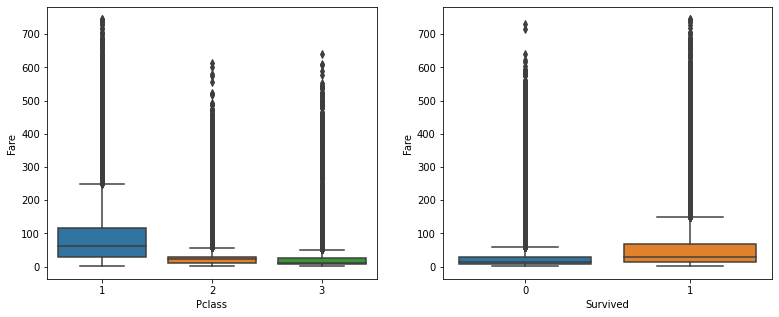

In [292]:
# `Fare -- Survived` и `Fare -- Pclass`
# логично, что чем лучше класс, тем стоимость дороже.
# поэтому тезис "кто платил больше тот выживал" - справедлив.
fig, ax = plt.subplots(2, 1, figsize=(13, 5))
plt.subplot(1,2,2)

sns.boxplot(x= train_data.Survived, y= train_data.Fare)
plt.subplot(1,2,1)
sns.boxplot(x= train_data.Pclass, y= train_data.Fare)

print ('медианное значение стоимости билета 1 класса:', train_data[train_data['Pclass'] == 1]['Fare'].median())
print ('медианное значение стоимости билета 2 класса:', train_data[train_data['Pclass'] == 2]['Fare'].median())
print ('медианное значение стоимости билета 3 класса:', train_data[train_data['Pclass'] == 3]['Fare'].median())
print ('среднее значение стоимости билета 1 класса:', train_data[train_data['Pclass'] == 1]['Fare'].mean())
print ('среднее значение стоимости билета 2 класса', train_data[train_data['Pclass'] == 2]['Fare'].mean())
print ('среднее значение стоимости билета 3 класса', train_data[train_data['Pclass'] == 3]['Fare'].mean())

###  Cabin

In [293]:
# в назавании кабины есть законономерность - начинается с огранич количества букв, которые могут обозначать номер палубы
# учитывая большое количество пропущенных значений, пропущенные названия кабин в строках могут означать, что пассажирам не была выделена отдельная кабина, а например кабина общего пользования 
# выживаемость пассажиров "без кабины" - значительно ниже чем в кабинах с названием (за исключением кабин, начинающихся с 'A' и 'T')
# создадим новый параметр 'Cabin_code'
train_data["Cabin_code"] = train_data["Cabin"].str[0]
train_data["Cabin_code"] = train_data["Cabin_code"].fillna("N")
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Cabin_code', values = 'Name' , aggfunc='count')
         /train_data.Cabin_code.value_counts()*100)

                  A          B          C          D          E          F  \
Survived                                                                     
0         72.538449  36.980777  28.778013  26.780313  38.250429  16.289593   
1         27.461551  63.019223  71.221987  73.219687  61.749571  83.710407   

                  G          N      T  
Survived                               
0         16.390041  65.789939  56.25  
1         83.609959  34.210061  43.75  


### Ticket

In [294]:
# Некоторые номера билетов имеют специальные буквенные символы, такие как A/5, CA, SC PARIS и т.д., в то время как многие просто цифровые. 
# Это может означать некоторую категоризацию билетов специального класса.
# Билеты с одними цифрами, а также пустые значения названы 'XX'.
# Для более компактного вида из названий билетов убраны знаки (точки, слэши)

train_data['TicketType'] = train_data.Ticket.fillna('XX')
train_data['TicketType'] = train_data.TicketType.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'XX')
train_data['TicketType'] = train_data['TicketType'].str.lower()
import re
train_data['TicketType'] = train_data.TicketType.map(lambda x: re.sub("[^\w\s]+","",x))

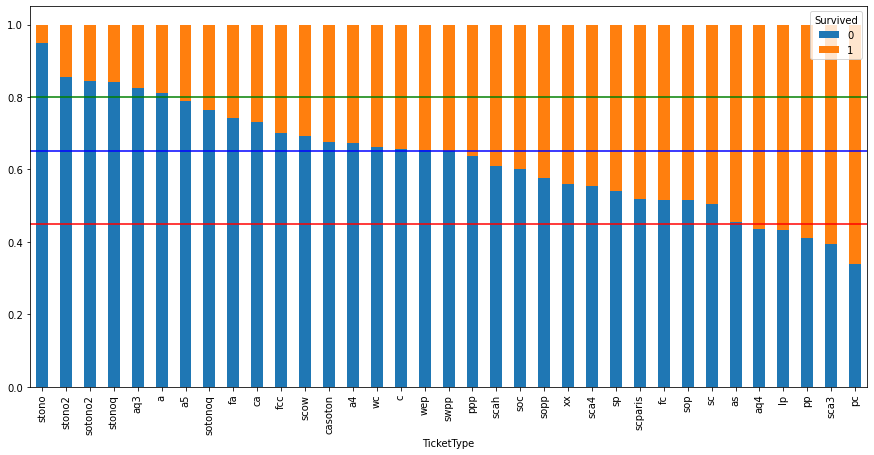

In [295]:
# Прослеживается корреляция категории билетов и выживаемости
pd.crosstab(index= train_data.TicketType, columns= train_data.Survived, normalize='index' ). \
sort_values(by = 1).plot.bar(figsize=(15, 7),stacked = True)

plt.axhline(y = 0.8, color = 'g', linestyle = '-')
plt.axhline(y = 0.65, color = 'b', linestyle = '-');
plt.axhline(y = 0.45, color = 'r', linestyle = '-');

In [296]:
# Категории билетов сгруппированы по коэффициенту выживаемости (свыше 80%, от около 65% до 80%, менее 45% и иные)
train_data['TT_bucket'] = train_data.TicketType.map(lambda x: 'c' if x in ['pc','sca3','pp','lp','aq4','as'] else 'a' if x in ['stono', 'stono2', 'sotono2', 'stonoq', 'aq3', 'a'] else 'b' if \
                                             x in ['sotonoq', 'fa', 'ca', 'fcc', 'scow', 'casoton', 'a4', 'a5'] else 'd')

train_data['TT_bucket'].value_counts()

d    81256
c     7165
a     6003
b     5576
Name: TT_bucket, dtype: int64

- `Fare -- Survived` и `Fare -- Pclass` : Чем лучше класс, тем стоимость билета дороже. Поэтому тезис "кто платил больше, тот выживал" - справедлив.
- `Fare` : признак имеет значительное кол-во выбросов. Медиана и среднее составляют 24.5 и 43.9 соответственно. Учитывая зависимость стоимости билета от класса, а также, что % пропущенных значений признака незначительный (0.13%), пропущенные значения предлагается заполнить медианой в зависимости от `Pclass`.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [297]:
# пропущенные значения 
missing_percentages = (train_data[train_data.columns].isnull().sum() / train_data.shape[0]) * 100
missing_percentages

Survived       0.000
Pclass         0.000
Name           0.000
Sex            0.000
Age            3.292
SibSp          0.000
Parch          0.000
Ticket         4.623
Fare           0.134
Cabin         67.866
Embarked       0.250
Cabin_code     0.000
TicketType     0.000
TT_bucket      0.000
dtype: float64

Поля с пропущенныеми данными в train_data

`Age` (3.292% от всех)

`Ticket` (4.623%)

`Fare` (0.134%)

`Cabin` (67.866%)

`Embarked` (0.250%)

In [298]:
# пропущенные значения 
missing_percentages = (test_data[test_data.columns].isnull().sum() / test_data.shape[0]) * 100
missing_percentages

Pclass       0.000
Name         0.000
Sex          0.000
Age          3.487
SibSp        0.000
Parch        0.000
Ticket       5.181
Fare         0.133
Cabin       70.831
Embarked     0.277
dtype: float64

Поля с пропущенныеми данными в test_data

`Age` (3.487% от всех)

`Ticket` (5.181%)

`Fare` (0.133%)

`Cabin` (70.831%)

`Embarked` (0.277%)

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Как правило недостающие значения можно заполнять средним значением, медианой или модой. Также можно проводить анализ на предмет нахождения закономерностей в значениях признаков (будет описано далее).

- `Age` : медианный и средний возраст практически равны: 39.0 и 38.4 соответственно. Пропущенные значения предлагается заполнить медианными значениями;
- `Fare` : признак имеет значительное кол-во выбросов. Медиана и среднее составляют 24.5 и 43.9 соответственно. Учитывая зависимость стоимости билета от класса, а также, что % пропущенных значений признака незначительный (0.13%), пропущенные значения предлагается заполнить медианой в зависимости от `Pclass`;
- `Embarked` : как указывал выше место посадки большинства пассажиров был Southampton (72 139 или 72.1%), затем Cherbourg (22 187 или 22.2%) и незначительная часть пассажиров села в Queenstown (5 424 или 5.4%). Учитывая, что % пропущенных значений признака незначительный (0.25%) пропущенные значения предлагается заполнить модой;
- `Cabine` : В `Cabine` есть законономерность - начинается с ограниченного количества букв, которые могут обозначать номер палубы. Учитывая большое количество пропущенных значений, пропущенные названия кабин в строках могут означать, что пассажирам не была выделена отдельная кабина, а выделена, например, кабина общего пользования. Выживаемость пассажиров "без кабины" - значительно ниже чем в кабинах с названием (за исключением кабин, начинающихся с 'A' и 'T'). Пропущенным значениям предлагается присвоить отдельную метку - 'N'.
    
    ! добавлено новое поле `Cabin_code` как первый символ из `Cabine` (если Nan - 'N')
    
- `Ticket` : Выявлена зависимость отдельных категорий билетов и уровня выживаемости. 
    
    ! добавлено новые поля `TicketType`, сформированное из значений `Ticket`, и `TT_bucket`, сгруппированное в зависимости от уровня выживаемости

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [299]:
# начнем все заново, учитывая результаты проведенного выше анализа
#объединим датасеты для корректного заполнения пропущенных значений
train_data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
dataset = pd.concat([train_data, test_data])
#пропущенные значения 'Age' заполним медианой
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
#пропущенные значения 'Fare' заполним медианой в зависимости от 'Pclass'
dataset['Fare'] = dataset.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
#пропущенные значения 'Embarked' заполним модой
dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
#добавим новое поле Cabin_code как первый символ из Cabine (если Nan - 'N')
dataset["Cabin_code"] = dataset["Cabin"].str[0]
dataset["Cabin_code"] = dataset["Cabin_code"].fillna("N")
#добавлено новые поля TicketType, сформированное из значений Ticket, 
#и TT_bucket, сгруппированное в зависимости от уровня выживаемости
dataset['TicketType'] = dataset.Ticket.fillna('XX')
dataset['TicketType'] = dataset.TicketType.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'XX')
dataset['TicketType'] = dataset['TicketType'].str.lower()
import re
dataset['TicketType'] = dataset.TicketType.map(lambda x: re.sub("[^\w\s]+","",x))
dataset['TT_bucket'] = dataset.TicketType.map(lambda x: 'c' if x in ['pc','sca3','pp','lp','aq4','as'] else 'a' if x in ['stono', 'stono2', 'sotono2', 'stonoq', 'aq3', 'a'] else 'b' if \
                                             x in ['sotonoq', 'fa', 'ca', 'fcc', 'scow', 'casoton', 'a4', 'a5'] else 'd')

In [300]:
# разобъем обратно на train и test
train_data = dataset[:100000]
test_data = dataset[100000:]
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_code,TicketType,TT_bucket
PassengerId,,,,,,,,,,,,,,
0,1.0,1,"Oconnor, Frankie",male,31.00,2,0,209245,31.00,C12239,S,C,xx,d
1,0.0,3,"Bryan, Drew",male,31.00,0,0,27323,31.00,NaN,S,N,xx,d
2,0.0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,0.33,NaN,S,N,ca,b
3,0.0,3,"Kramer, James",male,19.00,0,0,A. 10866,19.00,NaN,S,N,a,a
4,1.0,3,"Bond, Michael",male,25.00,0,0,427635,25.00,NaN,S,N,xx,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,2,"Bell, Adele",female,62.00,0,0,PC 15008,62.00,D17243,C,D,pc,c
99996,0.0,2,"Brown, Herman",male,66.00,0,0,13273,66.00,NaN,S,N,xx,d
99997,0.0,3,"Childress, Charles",male,37.00,0,0,NaN,37.00,NaN,S,N,xx,d


In [301]:
#определим колонки которые надо стандартизировать (числовые) и которые (категориальные) нужно привести в вид для читаемости моделью
target_col = 'Survived'
num_cols = ['Age','Fare']
cat_cols = ['Sex', 'Pclass','TT_bucket', 'Embarked','Cabin_code','SibSp', 'Parch']
num, cat = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
pre = ColumnTransformer([('num', num, num_cols), ('cat', cat, cat_cols)])
#создадим модели
log_model = Pipeline([('pre', pre), ('clf', LogisticRegression(C=0.15, max_iter=1000, random_state=42))])
knn_model = Pipeline([('pre', pre), ('clf', KNeighborsClassifier(n_neighbors=12))])

In [302]:
#результаты LogisticRegression, в том числе с кросс-валидацией
X, y = train_data[num_cols + cat_cols], train_data[target_col]
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
print( f'LogisticRegression model accuracy: {accuracy_score(y, log_model.fit(X=X, y=y).predict(X))}')
print( f'LogisticRegression model cross validate score (mean): {cross_validate(log_model, X, y, cv=k_fold)["test_score"].mean()}')

LogisticRegression model accuracy: 0.77477
LogisticRegression model cross validate score (mean): 0.7748999999999999


In [303]:
#результаты KNeighborsClassifier, в том числе с кросс-валидацией
print( f'KNeighborsClassifier model accuracy: {accuracy_score(y, knn_model.fit(X=X, y=y).predict(X))}')
print( f'KNeighborsClassifier model cross validate score (mean): {cross_validate(knn_model, X, y, cv=k_fold)["test_score"].mean()}')

KNeighborsClassifier model accuracy: 0.79011
KNeighborsClassifier model cross validate score (mean): 0.76723


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [304]:
#Попробуем повысить score путем добавления/группировки признаков
#Объединим 'SibSp' и 'Parch' как родственный признак
dataset['Family'] = dataset['SibSp'] + dataset['Parch']
#Выделим отдельно кто путешествовал один
dataset['AloneCode'] = LabelEncoder().fit_transform(dataset['Family'] == 0)

In [305]:
# разобъем обратно на train и test
train_data = dataset[:100000]
test_data = dataset[100000:]
train_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_code,TicketType,TT_bucket,Family,AloneCode
PassengerId,,,,,,,,,,,,,,,,
0,1.0,1,"Oconnor, Frankie",male,31.00,2,0,209245,31.00,C12239,S,C,xx,d,2,0
1,0.0,3,"Bryan, Drew",male,31.00,0,0,27323,31.00,NaN,S,N,xx,d,0,1
2,0.0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,0.33,NaN,S,N,ca,b,3,0
3,0.0,3,"Kramer, James",male,19.00,0,0,A. 10866,19.00,NaN,S,N,a,a,0,1
4,1.0,3,"Bond, Michael",male,25.00,0,0,427635,25.00,NaN,S,N,xx,d,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,2,"Bell, Adele",female,62.00,0,0,PC 15008,62.00,D17243,C,D,pc,c,0,1
99996,0.0,2,"Brown, Herman",male,66.00,0,0,13273,66.00,NaN,S,N,xx,d,0,1
99997,0.0,3,"Childress, Charles",male,37.00,0,0,NaN,37.00,NaN,S,N,xx,d,0,1


In [306]:
# аналогично определяем колонки
target_col = 'Survived'
num_cols = ['Age','Fare']
cat_cols = ['Sex', 'Pclass','TT_bucket', 'Embarked','Cabin_code', 'Family', 'AloneCode']
num, cat = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
pre = ColumnTransformer([('num', num, num_cols), ('cat', cat, cat_cols)])
log_model = Pipeline([('pre', pre), ('clf', LogisticRegression(C=0.15, max_iter=1000, random_state=42))])
knn_model = Pipeline([('pre', pre), ('clf', KNeighborsClassifier(n_neighbors=12))])

In [307]:
#стало немного лучше без кросс-валидации и немного хуже с ней
X, y = train_data[num_cols + cat_cols], train_data[target_col]
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
print( f'LogisticRegression model accuracy: {accuracy_score(y, log_model.fit(X=X, y=y).predict(X))}')
print( f'LogisticRegression model cross validate score (mean): {cross_validate(log_model, X, y, cv=k_fold)["test_score"].mean()}')

LogisticRegression model accuracy: 0.77491
LogisticRegression model cross validate score (mean): 0.7747299999999999


In [308]:
#на этой модели результаты немного хуже
print( f'KNeighborsClassifier model accuracy: {accuracy_score(y, knn_model.fit(X=X, y=y).predict(X))}')
print( f'KNeighborsClassifier model cross validate score (mean): {cross_validate(knn_model, X, y, cv=k_fold)["test_score"].mean()}')

KNeighborsClassifier model accuracy: 0.78578
KNeighborsClassifier model cross validate score (mean): 0.76753


Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [309]:
# в итоге я отдельно комбинировал признаки и лучший score показала эта комбинация с LogisticRegression
# долго не мог пробить отметку score в 80%
# Потом немного расширил границы  'TT_bucket' для группировки и в итоге получил выше 80%

target_col = 'Survived'
num_cols = ['Age','Fare']
cat_cols = ['Sex','Pclass','TT_bucket','Cabin_code', 'AloneCode']
num, cat = StandardScaler(), OneHotEncoder(handle_unknown='ignore')
pre = ColumnTransformer([('num', num, num_cols), ('cat', cat, cat_cols)])
#создадим модели
log_model = Pipeline([('pre', pre), ('clf', LogisticRegression(C=0.15, max_iter=1000, random_state=42))])
knn_model = Pipeline([('pre', pre), ('clf', KNeighborsClassifier(n_neighbors=12))])

In [310]:
log_model.fit(train_data[num_cols + cat_cols], train_data[target_col]);

In [311]:
result = pd.DataFrame()
test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))
result['PassengerId'] = test.PassengerId
result['Survived'] = log_model.predict(test_data[num_cols + cat_cols])
result.to_csv('titanic/my_result.csv', index=False)

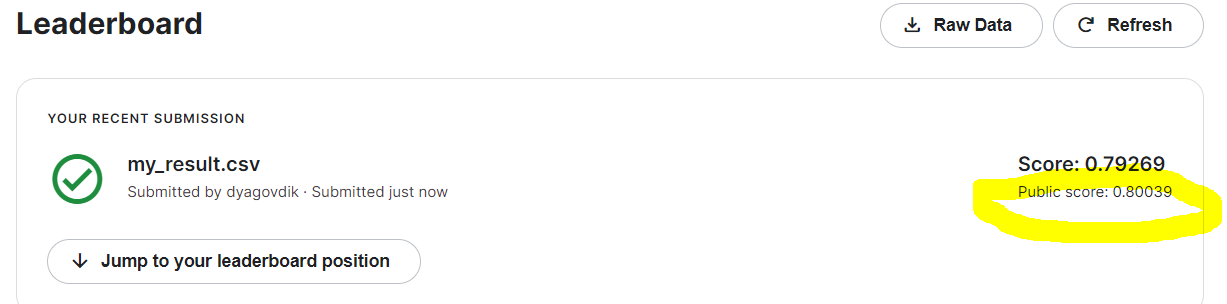

In [316]:
from IPython.display import Image
Image('Снимок.png')